# Load forecasting of Bangladesh using one time series analysis technique of machine learning (XGboost) (2017-2019)


In [65]:
# # Hide the code by default from the web page:
# # (from: http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer#28073228)
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>
''')

In [1]:
#Importing necessary files
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
#Merging the csv files of three years into one csv file
import glob
path = r'C:\Users\Md Samsul Alam\Dropbox\Anaconda_directory\Load forecasting\Using ML\with XGBoost' # use your path
three_years_data = glob.glob(path + "/*.csv")

single_year = []

for filename in three_years_data:
    data = pd.read_csv(filename, index_col=[0], parse_dates=[0])
    single_year.append(data)

df = pd.concat(single_year)    788                                         

In [3]:
df.head(10)

,loads
date_time,
2017-01-01 01:00:00,4807.0
2017-01-01 02:00:00,4525.0
2017-01-01 03:00:00,4395.0
2017-01-01 04:00:00,4211.0
2017-01-01 05:00:00,4197.0
2017-01-01 06:00:00,4415.0
2017-01-01 07:00:00,4620.0
2017-01-01 08:00:00,4957.0
2017-01-01 09:00:00,5515.0


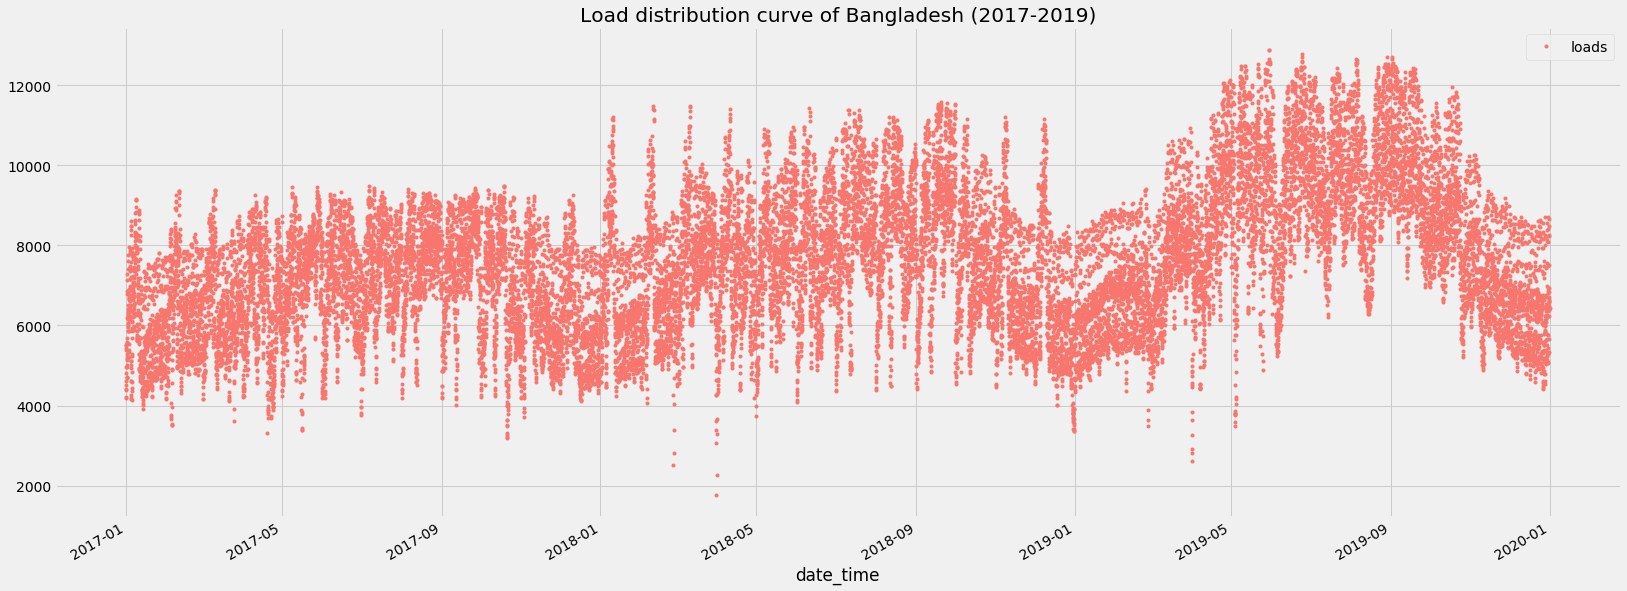

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
df.plot(style='.', figsize=(25,10), color=color_pal[0], title='Load distribution curve of Bangladesh (2017-2019)')

# Yearly demand distribution

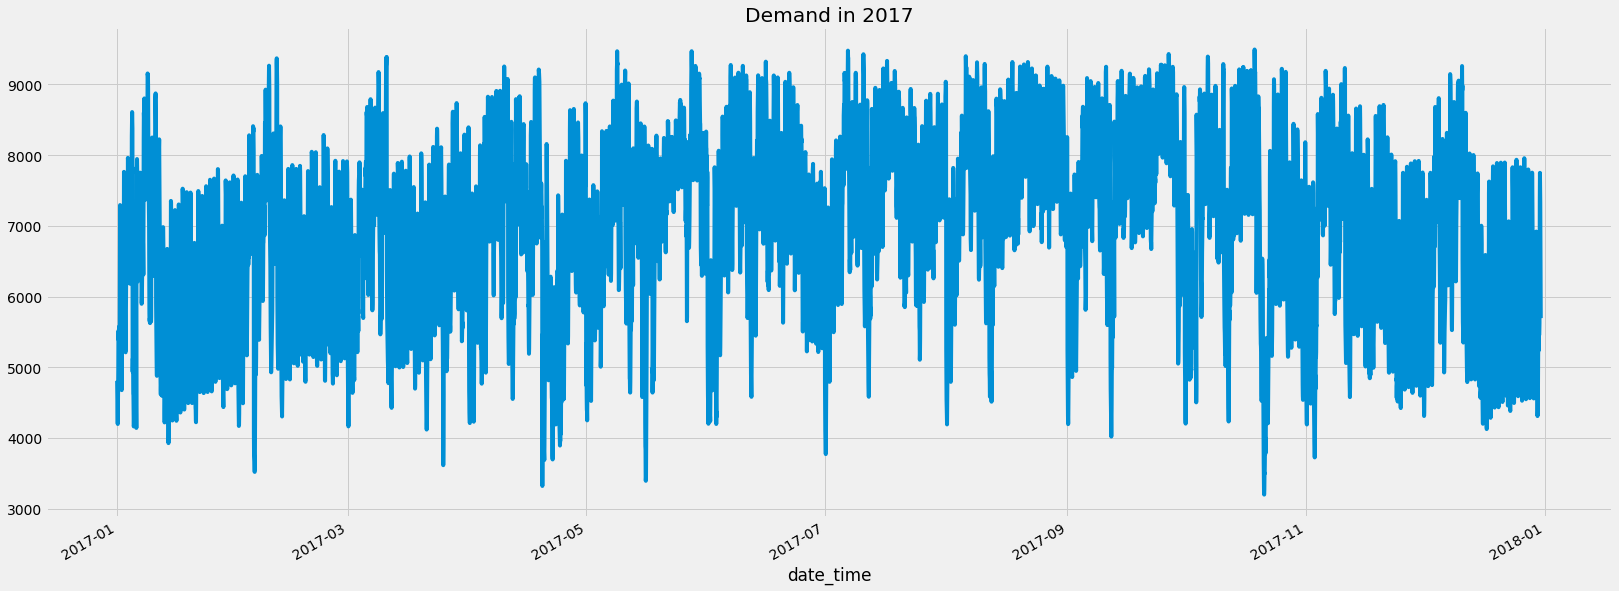

In [5]:
df['loads'].loc[(df['loads'].index <='2017-12-31')].plot(figsize=(25,10),title='Demand in 2017')

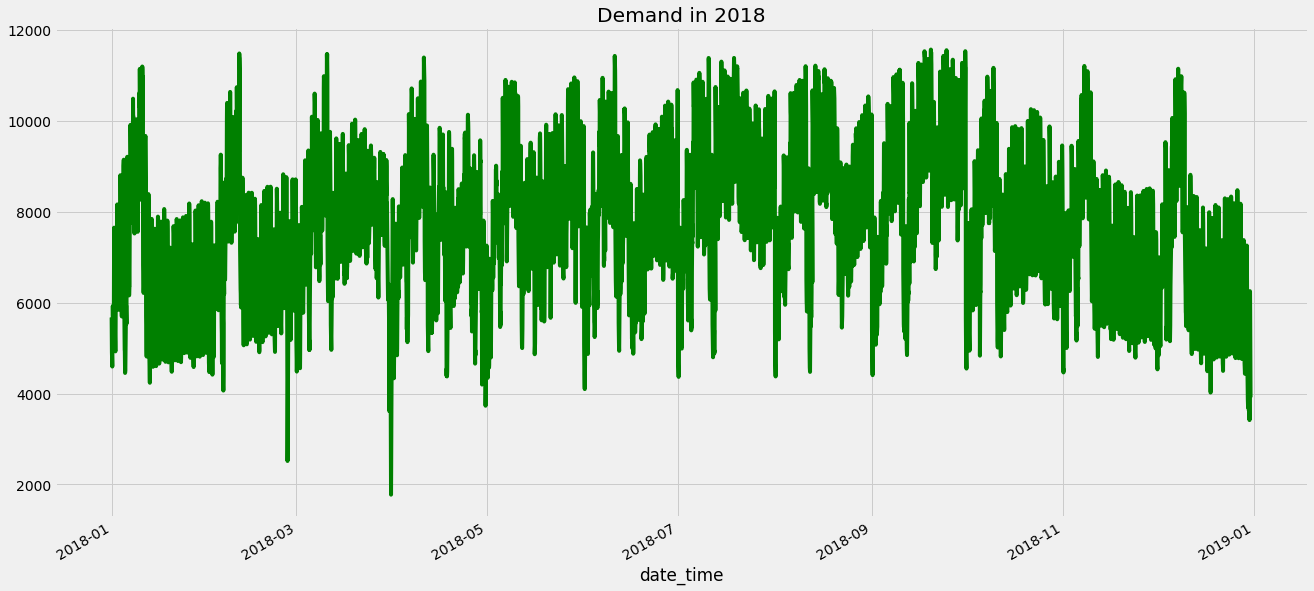

In [6]:
df['loads'].loc[(df['loads'].index <='2018-12-31') & (df['loads'].index >= '2018-01-01')].plot(figsize=(20,10),color='g', title='Demand in 2018')

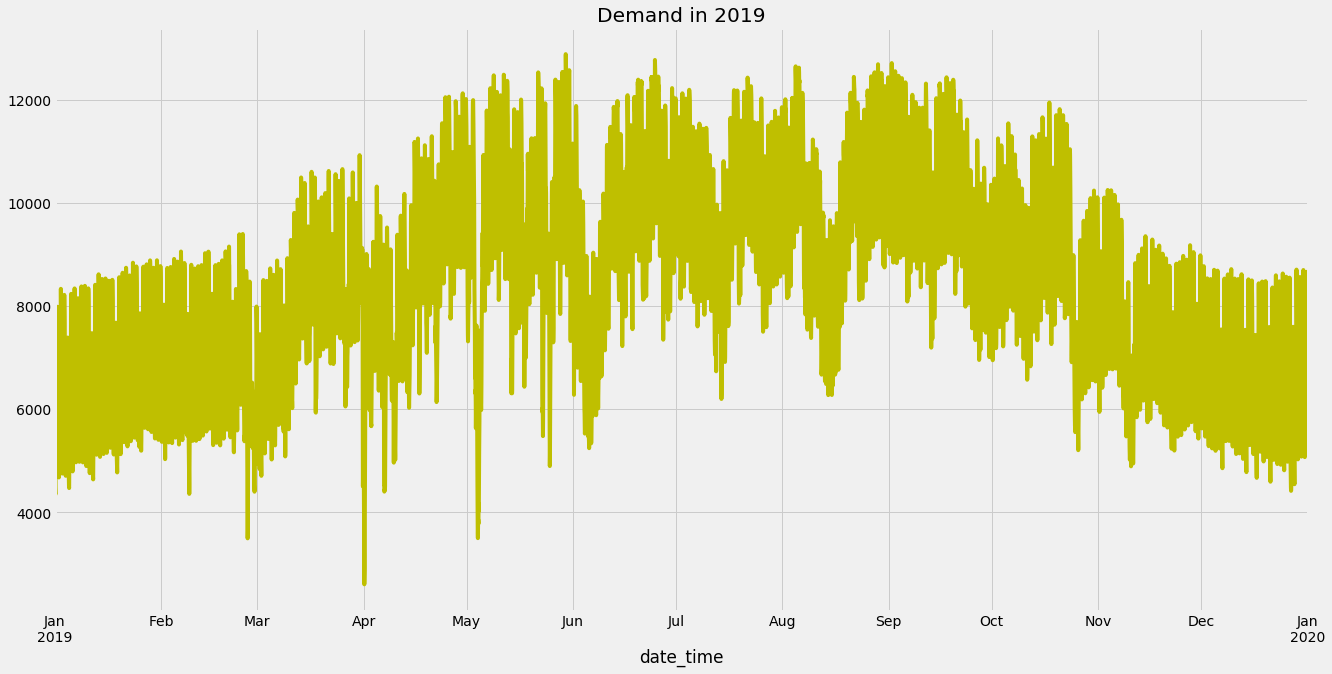

In [7]:
df['loads'].loc[(df['loads'].index >='2019-01-01')].plot(figsize=(20,10),color='y',title='Demand in 2019')

# Preparing data for training and testing

In [8]:
split_date = '01-01-2019'
df_train =df.loc[df.index <= split_date].copy()
df_test =df.loc[df.index > split_date].copy()

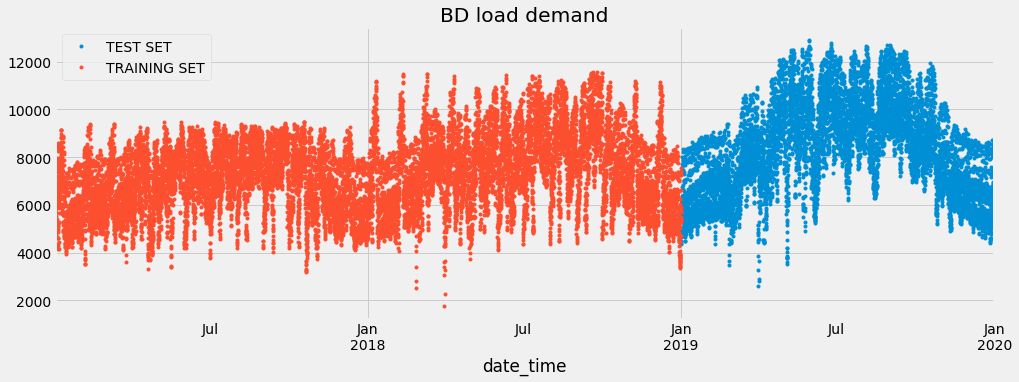

In [9]:
df_test.rename(columns={'loads': 'TEST SET'}) \
    .join(df_train.rename(columns={'loads': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='BD load demand', style='.')

# Create Time Series Features

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
X_train, y_train = create_features(df_train, label='loads')
X_test, y_test = create_features(df_test, label='loads')

# Create XGBoost Model

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

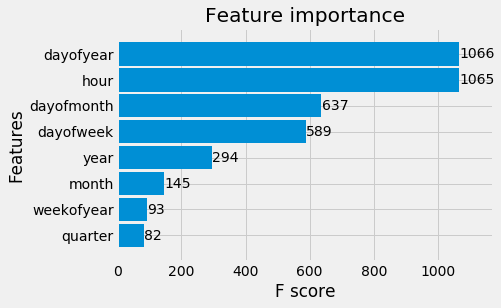

In [13]:
plot_importance(reg, height=0.9)

# Forecast on Test Set

In [14]:
df_test['MW_Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [15]:
df_all.head()


,loads,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
date_time,,,,,,,,,,,
2019-01-01 01:00:00,4984.0,2019-01-01 01:00:00,1,1,1,1,2019,1,1,1,5314.390625
2019-01-01 02:00:00,4644.0,2019-01-01 02:00:00,2,1,1,1,2019,1,1,1,5042.840820
2019-01-01 03:00:00,4487.0,2019-01-01 03:00:00,3,1,1,1,2019,1,1,1,4879.201660
2019-01-01 04:00:00,4399.0,2019-01-01 04:00:00,4,1,1,1,2019,1,1,1,4754.636719
2019-01-01 05:00:00,4350.0,2019-01-01 05:00:00,5,1,1,1,2019,1,1,1,4639.765137


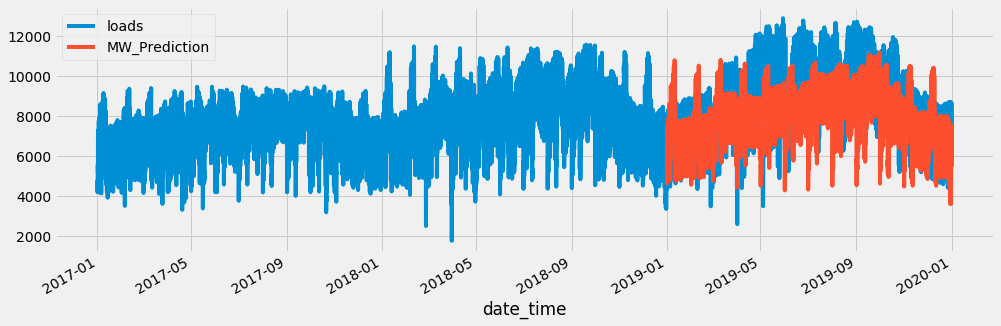

In [16]:
_ = df_all[['loads','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

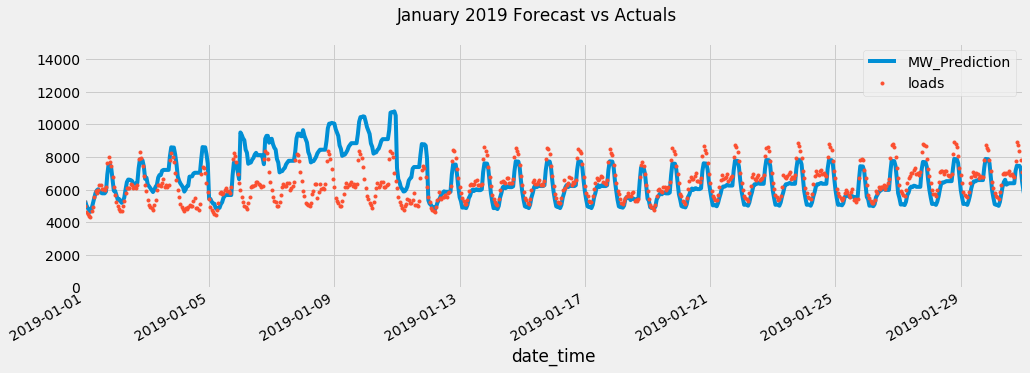

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','loads']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2019-01-01', upper='2019-01-31')
ax.set_ylim(0, 15000)
plot = plt.suptitle('January 2019 Forecast vs Actuals')

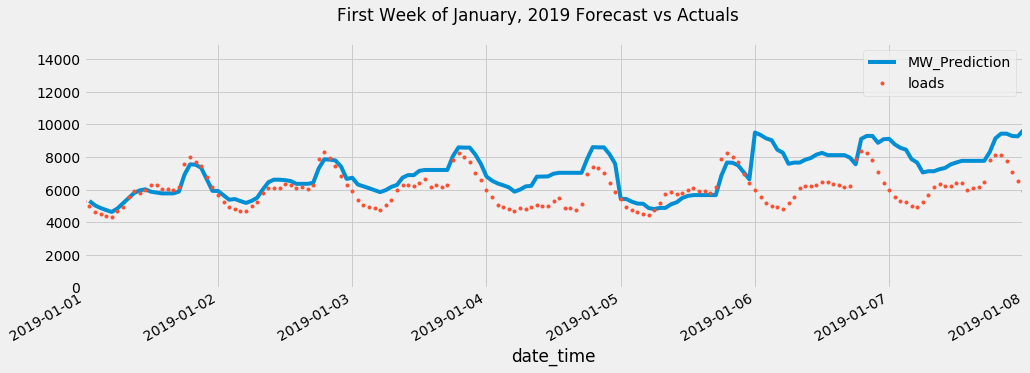

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','loads']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2019-01-01', upper='2019-01-08')
ax.set_ylim(0, 15000)
plot = plt.suptitle('First Week of January, 2019 Forecast vs Actuals')

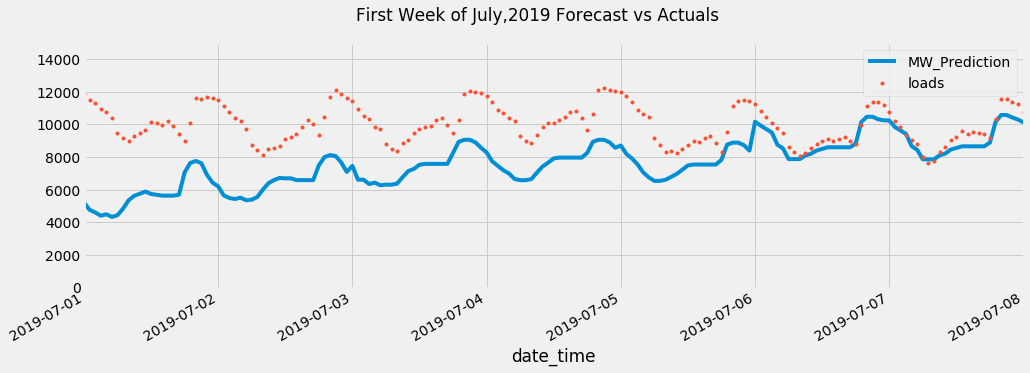

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['MW_Prediction','loads']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 15000)
ax.set_xbound(lower='2019-07-01', upper='2019-07-08')
plot = plt.suptitle('First Week of July,2019 Forecast vs Actuals')

# Error Metrics On Test Set

In [20]:
mean_squared_error(y_true=df_test['loads'],
                   y_pred=df_test['MW_Prediction'])

2965032.9533133716

In [21]:
mean_absolute_error(y_true=df_test['loads'],
                   y_pred=df_test['MW_Prediction'])

1342.1403727369614

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mean_absolute_percentage_error(y_true=df_test['loads'],
                   y_pred=df_test['MW_Prediction'])

15.75549170701343

# Look at Worst and Best Predicted Days

In [24]:
df_test['error'] = df_test['loads'] - df_test['MW_Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['loads','MW_Prediction','error','abs_error']]

# Over forecasted days

In [25]:
error_by_day.sort_values('error', ascending=True).head(10)

loads  MW_Prediction        error    abs_error
year month dayofmonth                                                      
2019 12    6           5956.880833    8994.115234 -3037.234076  3037.234076
     1     10          6343.908333    9361.252930 -3017.344881  3017.344881
     12    7           6320.187500    9319.593750 -2999.406576  2999.406576
     1     9           6363.221667    9161.496094 -2798.274508  2798.274508
     12    8           6719.351250    9392.729492 -2673.378364  2673.378364
     1     8           6237.279167    8760.261719 -2522.983020  2522.983020
     2     8           6192.895833    8713.820312 -2520.924337  2520.924337
     11    10          5761.699583    8265.178711 -2503.478904  2503.478904
     4     9           6392.049167    8748.759766 -2356.710884  2356.710884
     2     10          6758.243333    9089.299805 -2331.056390  2331.056390

# Under forecasted day

In [26]:
error_by_day.sort_values('error', ascending=False).head(10)

loads  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2019 9     1           11009.269583    5729.312988  5279.956656  5279.956656
     7     1           10337.151250    5714.646484  4622.504928  4622.504928
     8     1           10166.137500    5778.122070  4388.015613  4388.015613
     9     2           10606.080417    6344.965332  4261.114963  4261.114963
     5     2           10157.819167    6190.872559  3966.946608  3966.946608
     6     1            9460.925833    5594.115723  3866.809989  3866.809989
     8     5           11031.496667    7237.166992  3794.329674  3794.329674
     5     12          10497.548333    6782.184082  3715.364394  3715.364394
           1            9198.228750    5561.261719  3636.967235  3636.967235
     9     11          10432.721667    6944.091309  3488.630256  3488.630256

# Worst absolute predicted days

In [27]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

loads  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2019 9     1           11009.269583    5729.312988  5279.956656  5279.956656
     7     1           10337.151250    5714.646484  4622.504928  4622.504928
     8     1           10166.137500    5778.122070  4388.015613  4388.015613
     9     2           10606.080417    6344.965332  4261.114963  4261.114963
     5     2           10157.819167    6190.872559  3966.946608  3966.946608
     6     1            9460.925833    5594.115723  3866.809989  3866.809989
     8     5           11031.496667    7237.166992  3794.329674  3794.329674
     5     12          10497.548333    6782.184082  3715.364394  3715.364394
           1            9198.228750    5561.261719  3636.967235  3636.967235
     9     11          10432.721667    6944.091309  3488.630256  3488.630256

# Best predicted days

In [28]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

loads  MW_Prediction       error   abs_error
year month dayofmonth                                                    
2019 12    13          5860.575833    5924.279297  -63.703687  187.391653
           25          6347.953333    6202.634277  145.318934  206.137241
           2           6650.836667    6722.871582  -72.034915  236.179754
     2     22          6266.400000    6257.895996    8.503780  238.930253
     8     8           9040.593333    9024.657227   15.936453  239.272146
     12    26          6441.729167    6202.634277  239.094767  242.420614
     1     18          5961.616667    5738.749512  222.867358  246.763298
     10    27          7544.520000    7500.739258   43.780681  256.312747
     12    20          5898.452083    5647.488770  250.963497  260.353350
           17          6360.139583    6166.881348  193.258236  262.713232

# Plotting some of the best and worst predicted days

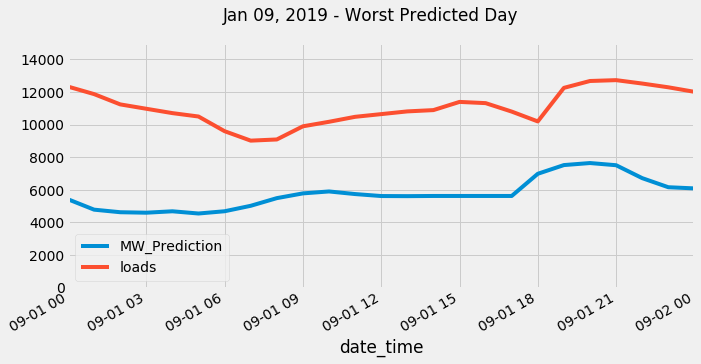

In [29]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_Prediction','loads']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(0, 15000)
ax.set_xbound(lower='2019-09-01', upper='2019-09-02')
plot = plt.suptitle('Jan 09, 2019 - Worst Predicted Day')

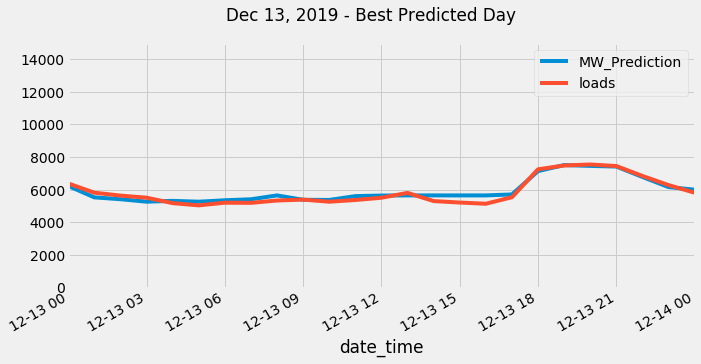

In [30]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[['MW_Prediction','loads']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(0, 15000)
ax.set_xbound(lower='2019-12-13', upper='2019-12-14')
plot = plt.suptitle('Dec 13, 2019 - Best Predicted Day')

# Comparison of some other predicted loads with original loads

In [31]:
data=df
y_true=df_test['loads']
X_test_pred=df_test['MW_Prediction']


In [32]:
def plot_performance(base_data, test_data, test_pred, date_from, date_to, title=None):
    plt.figure(figsize=(15,6))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title( title )
    plt.xlabel( 'Time' )
    plt.ylabel( 'Energy consumed ( MW )' )
    plt.plot( base_data.index,base_data['loads'], label='data' )
    plt.plot( test_data.index, test_pred, label='prediction' )
    plt.xlim( left=date_from, right=date_to )
    plt.legend()

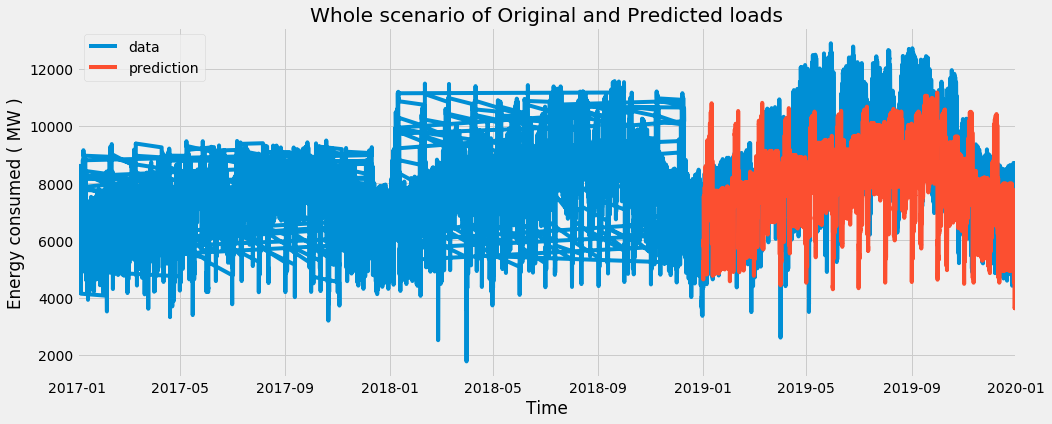

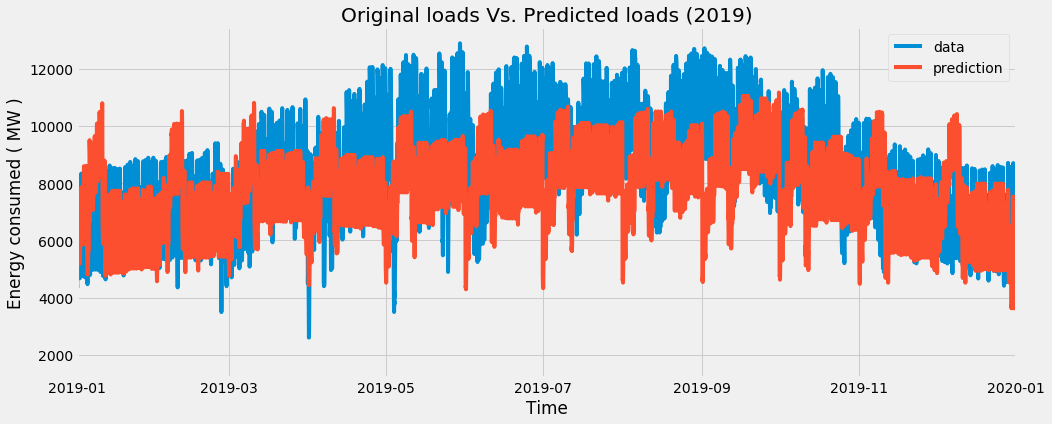

In [33]:
plot_performance(data, X_test, X_test_pred, data.index[0].date(), data.index[-1].date(),
                 'Whole scenario of Original and Predicted loads')

plot_performance(data, X_test, X_test_pred, y_test.index[0].date(), y_test.index[-1].date(),
                 'Original loads Vs. Predicted loads (2019)')



plt.show()

# Plotting the load distribution of individual month wise original Vs. predicted loads in MW of 2019

In [34]:
df_for_plot=df_all.drop(['dayofweek','quarter','dayofyear','weekofyear'],axis=1)
df_for_plot['Error'] = df_test['loads'] - df_test['MW_Prediction']
df_for_plot['Abs_error'] = df_test['error'].apply(np.abs)

In [35]:
df_for_plot.rename(columns = {'loads':'Original Load', 'MW_Prediction':'Predicted Load'}, inplace = True)
df_for_plot.head()

,Original Load,date,hour,month,year,dayofmonth,Predicted Load,Error,Abs_error
date_time,,,,,,,,,
2019-01-01 01:00:00,4984.0,2019-01-01 01:00:00,1,1,2019,1,5314.390625,-330.390625,330.390625
2019-01-01 02:00:00,4644.0,2019-01-01 02:00:00,2,1,2019,1,5042.840820,-398.840820,398.840820
2019-01-01 03:00:00,4487.0,2019-01-01 03:00:00,3,1,2019,1,4879.201660,-392.201660,392.201660
2019-01-01 04:00:00,4399.0,2019-01-01 04:00:00,4,1,2019,1,4754.636719,-355.636719,355.636719
2019-01-01 05:00:00,4350.0,2019-01-01 05:00:00,5,1,2019,1,4639.765137,-289.765137,289.765137


In [36]:
#Function for showing month wise data and plot.
def month_wise_plot(data_frame, lower_limit, upper_limit,Month_name):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    _ = data_frame[['Predicted Load','Original Load']].plot(ax=ax, style=['-','-'], color=['b','g'])
    ax.set_ylim(0, 15000)
    ax.set_xbound(lower_limit, upper_limit)
    plot = plt.suptitle(Month_name +', 2019')
    
    #Sorting data monthly based on best and worst error
    #Selecting the defined month
    # Select observations between two datetimes
    month_selection=df_for_plot[(df_for_plot['date'] > lower_limit) & (df_for_plot['date'] <=upper_limit)]
    error_by_day = month_selection.groupby(['dayofmonth']) \
    .mean()[['Original Load','Predicted Load','Error','Abs_error']]
    
   
    # Best predicted days
    best=error_by_day.sort_values('Abs_error', ascending=True).head(5)
    print("Top five best predicted day of " + Month_name + '\n\n')
    print(best)
    print('\n\n')
    
    # worst predicted days 
    worst=error_by_day.sort_values('Abs_error', ascending=False).head(5)
    print("Top five worst predicted day of " + Month_name + '\n\n')
    print(worst)
    print('\n\n')


# January 2019

Top five best predicted day of January


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
18            5961.616667     5738.749512  222.867358  246.763298
1             5925.474348     5858.959961   66.514472  274.440352
12            5982.397917     5859.058594  123.339242  309.170168
25            6119.320833     5859.861816  259.459241  319.346545
19            6244.218750     5898.401367  345.817261  352.373576



Top five worst predicted day of January


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
10            6343.908333     9361.252930 -3017.344881  3017.344881
9             6363.221667     9161.496094 -2798.274508  2798.274508
8             6237.279167     8760.261719 -2522.983020  2522.983020
6             6286.012917     8440.374023 -2154.361025  2182.439801
7             6291.183333     8140.192871 -1

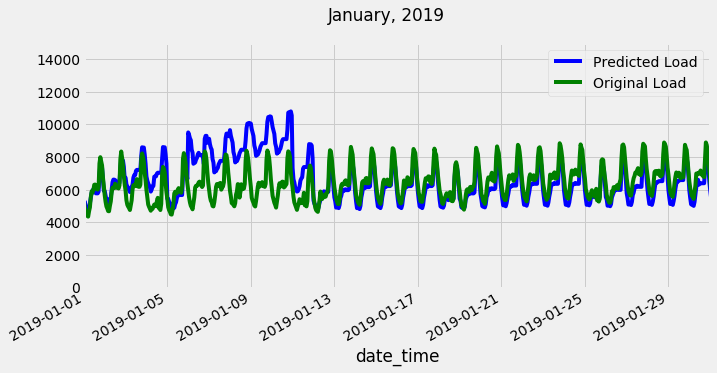

In [37]:
month_wise_plot(df_for_plot, lower_limit='2019-01-01', upper_limit='2019-01-31', Month_name='January')

# February 2019

Top five best predicted day of February


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
22            6266.400000     6257.895996    8.503780  238.930253
15            6438.321250     6286.580566  151.740602  269.275856
21            6485.888750     6591.068359 -105.179386  286.510660
18            6879.629167     6566.274902  313.354061  333.157365
3             6926.820833     6830.114746   96.706189  347.109713



Top five worst predicted day of February


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
8             6192.895833     8713.820312 -2520.924337  2520.924337
10            6758.243333     9089.299805 -2331.056390  2331.056390
9             6426.216667     8748.236328 -2322.019743  2322.019743
7             6992.995833     8718.208984 -1725.213619  1725.213619
6             6853.456250     8331.558594 

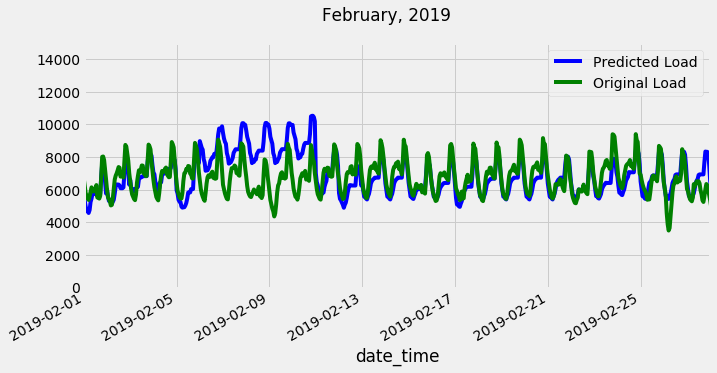

In [38]:
month_wise_plot(df_for_plot, lower_limit='2019-02-01', upper_limit='2019-02-28', Month_name='February')

# March 2019

Top five best predicted day of March


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
2             6296.000417     6383.906738  -87.906525  289.253354
1             5640.456522     5874.680176 -234.223845  367.365914
15            7765.475000     7418.315430  347.159550  377.133036
27            8011.993333     7763.619141  248.374355  441.248957
5             6547.645833     6870.837402 -323.191650  474.961808



Top five worst predicted day of March


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
31            9753.000000     7168.158203  2584.841797  2584.841797
9             6701.942500     8900.352539 -2198.410263  2198.410263
8             6324.370000     8452.825195 -2128.455460  2128.455460
10            7269.612500     9257.068359 -1987.455371  1987.455371
6             6809.566667     8691.629883 -1882.

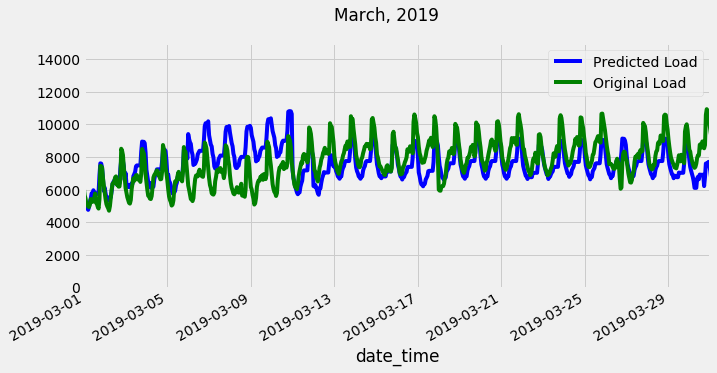

In [39]:
month_wise_plot(df_for_plot, lower_limit='2019-03-01', upper_limit='2019-03-31', Month_name='March')

# April 2019

Top five best predicted day of April


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
3             7287.521667     7427.816895 -140.295085  418.926222
14            7650.373333     7509.375977  140.997560  484.202716
22            7896.402500     7528.789062  367.613193  575.364276
5             7697.041667     6990.322266  706.719401  730.059173
4             8288.891250     7451.548828  837.342279  837.342279



Top five worst predicted day of April


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
30           11262.000000     7160.357910  4101.642090  4101.642090
28           10244.366667     7410.598145  2833.768705  2833.768705
29           10315.234167     7504.068848  2811.165197  2811.165197
25           10359.937500     7553.582520  2806.355164  2806.355164
27           10086.745417     7421.382324  2665.

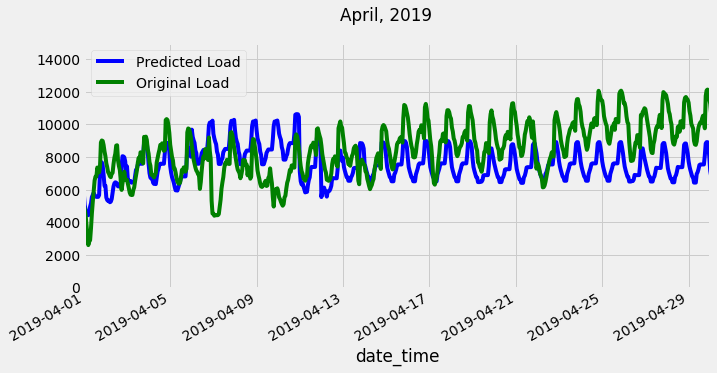

In [40]:
month_wise_plot(df_for_plot, lower_limit='2019-04-01', upper_limit='2019-04-30', Month_name='April')

# MAY 2019

Top five best predicted day of May


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
25            7695.712500     8048.838867  -353.126184   769.449540
6             9712.941250     8880.041016   832.900682   832.900682
24            8941.805000     7864.389648  1077.415392  1111.665555
10           10109.279167     8983.996094  1125.282849  1125.282849
5             8186.658333     7282.168457   904.489998  1150.913354



Top five worst predicted day of May


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
2            10157.819167     6190.872559  3966.946608  3966.946608
12           10497.548333     6782.184082  3715.364394  3715.364394
1             9114.847391     5561.602051  3553.245341  3553.245341
11           10655.714583     7341.770508  3313.943974  3313.943974
29           10834.490000     8216.803

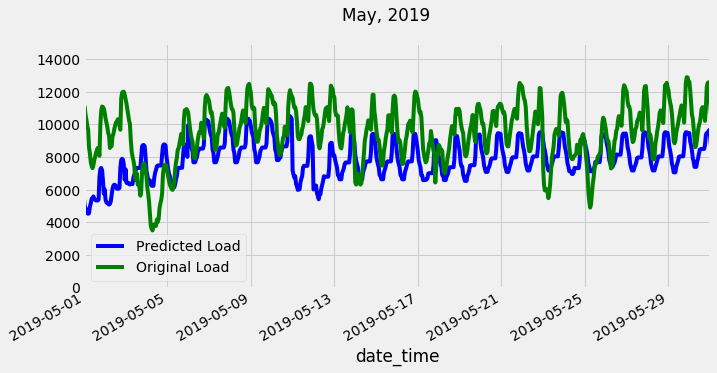

In [41]:
month_wise_plot(df_for_plot, lower_limit='2019-05-01', upper_limit='2019-05-31', Month_name='May')

# June 2019

Top five best predicted day of June


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
10            8996.546667     8972.277344    24.268875   353.482414
9             8209.229583     8891.756836  -682.527334   682.527334
3             8082.697083     7266.474121   816.222759   847.299002
5             6563.944583     7586.475586 -1022.531186  1084.590715
4             7216.300417     7687.170898  -470.870685  1204.721548



Top five worst predicted day of June


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
1             9399.270435     5614.981445  3784.288798  3784.288798
12           10368.508333     6927.874512  3440.634045  3440.634045
19           10890.991667     7826.645020  3064.346667  3064.346667
20           10805.680417     7871.243164  2934.437395  2934.437395
25           11112.370000     8295.6

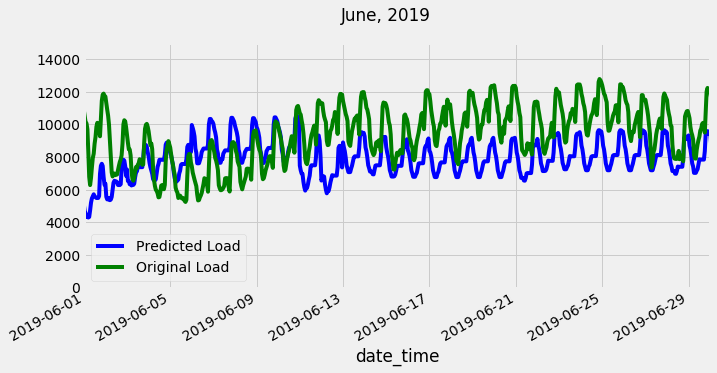

In [42]:
month_wise_plot(df_for_plot, lower_limit='2019-06-01', upper_limit='2019-06-30', Month_name='June')

# July 2019

Top five best predicted day of July


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
13            8601.066250     8673.873047  -72.806492  312.066082
10            9582.856667     9153.814453  429.042356  464.499543
9             9504.611667     9024.975586  479.636386  480.219543
15            8478.608333     8789.789062 -311.180811  523.676452
7             9551.075833     9055.420898  495.654731  528.261284



Top five worst predicted day of July


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
1            10270.114348     5736.083984  4534.030512  4534.030512
2             9991.745833     6518.429199  3473.316675  3473.316675
4            10556.155000     7781.363770  2774.791149  2774.791149
3            10142.347083     7420.746094  2721.600888  2721.600888
5             9818.353333     7645.402832  2172.95

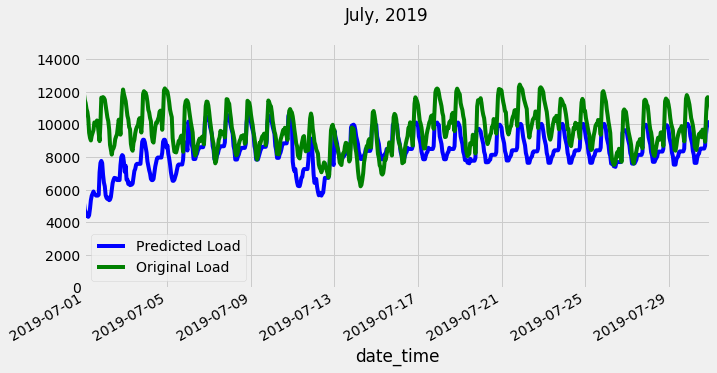

In [43]:
month_wise_plot(df_for_plot, lower_limit='2019-07-01', upper_limit='2019-07-31', Month_name='July')

# August 2019

Top five best predicted day of August


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
8             9040.593333     9024.657227   15.936453  239.272146
18            9235.520833     9133.299805  102.220581  294.474588
9             9044.594583     8997.736328   46.858560  390.792478
10            9272.768750     9137.162109  135.606376  451.622974
17            8500.280000     8986.620117 -486.340239  598.076685



Top five worst predicted day of August


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
1            10115.849130     5796.235352  4319.613736  4319.613736
5            11031.496667     7237.166992  3794.329674  3794.329674
2             9653.793750     6363.291016  3290.502938  3290.502938
4            10708.810833     7732.458984  2976.351869  2976.351869
31           12122.270000     9164.111328  295

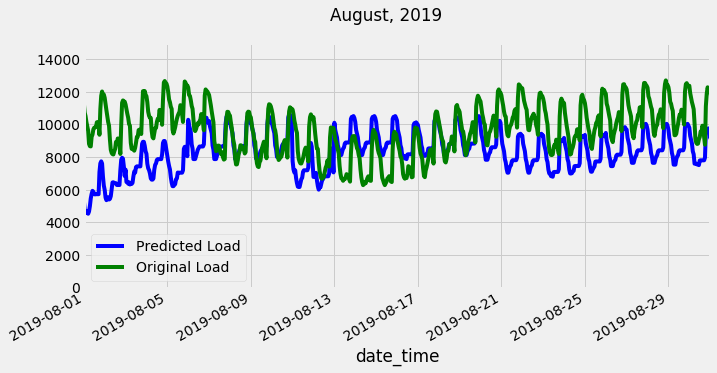

In [44]:
month_wise_plot(df_for_plot, lower_limit='2019-08-01', upper_limit='2019-08-31', Month_name='August')

# September 2019

Top five best predicted day of September


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
24            9207.109583     9478.904297 -271.794876  279.851107
23            9714.711667     9454.111328  260.600339  344.671807
13            8708.723333     8287.946289  420.777431  472.015704
27            8442.962917     8944.430664 -501.467646  501.467646
26            8901.879167     9308.004883 -406.125675  510.727700



Top five worst predicted day of September


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
1            10952.116087     5742.763672  5209.352203  5209.352203
2            10606.080417     6344.965332  4261.114963  4261.114963
11           10432.721667     6944.091309  3488.630256  3488.630256
3            10716.906667     7282.371582  3434.535166  3434.535166
12            9837.114167     6693.32519

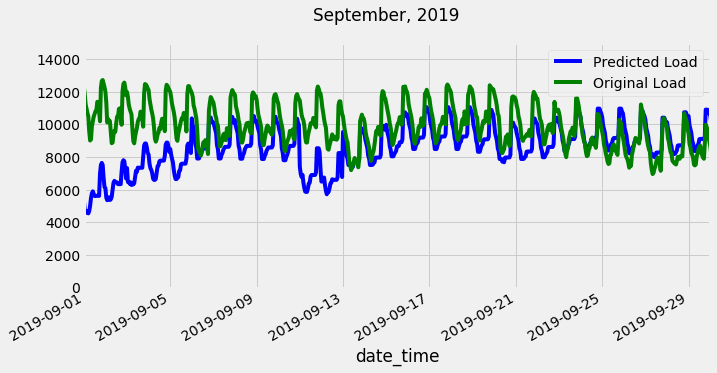

In [45]:
month_wise_plot(df_for_plot, lower_limit='2019-09-01', upper_limit='2019-09-30', Month_name='September')

# October 2019

Top five best predicted day of October


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
27            7544.520000     7500.739258   43.780681  256.312747
10            8345.825000     8324.266602   21.558297  272.423567
28            7690.441250     7511.120117  179.321296  336.172046
8             8729.710000     9088.077148 -358.366681  438.654965
7             9348.894583     9058.773438  290.121248  502.713993



Top five worst predicted day of October


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
2             8839.276250     6328.343262  2510.932927  2510.932927
1             8318.854783     5887.277832  2431.576929  2431.576929
12            8773.742500     6381.913086  2391.829434  2391.829434
3             9215.486250     7229.967773  1985.518314  1985.518314
5             9461.597917     7546.149414  1

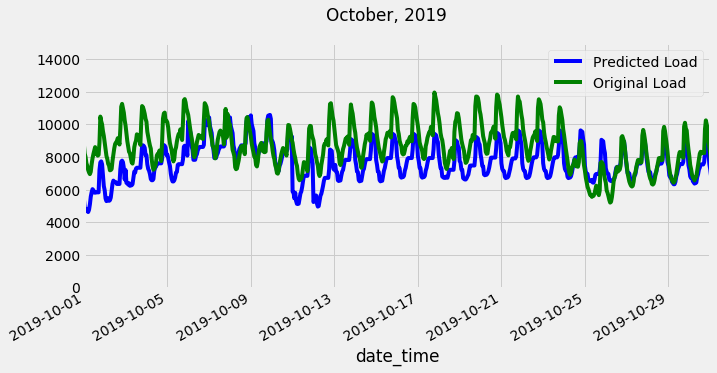

In [46]:
month_wise_plot(df_for_plot, lower_limit='2019-10-01', upper_limit='2019-10-31', Month_name='October')

# November 2019

Top five best predicted day of November


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
22            6138.894167     6023.465332  115.428733  265.407249
23            6583.315417     6291.457031  291.858589  321.948066
20            6989.655417     6617.222656  372.432862  372.432862
15            6748.109583     6362.473145  385.636500  392.379594
11            6651.044583     6271.474121  379.570625  399.753226



Top five worst predicted day of November


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
10            5761.699583     8265.178711 -2503.478904  2503.478904
9             6851.944167     8937.322266 -2085.378079  2085.378079
8             6905.000833     8916.869141 -2011.868002  2011.868002
2             7902.788750     6421.697266  1481.091464  1481.091464
1             7184.074783     5843.333008 

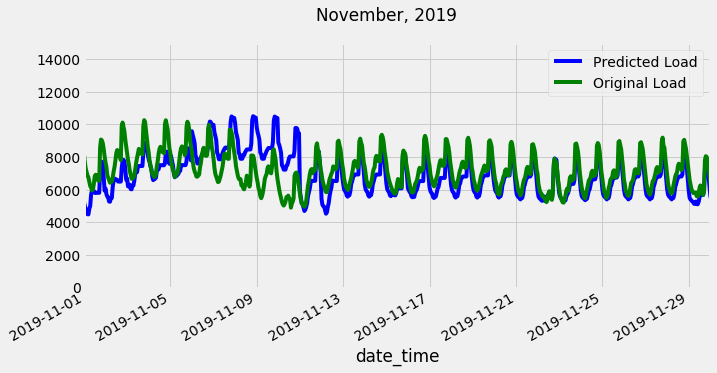

In [47]:
month_wise_plot(df_for_plot, lower_limit='2019-11-01', upper_limit='2019-11-30', Month_name='November')

# December 2019

Top five best predicted day of December


            Original Load  Predicted Load       Error   Abs_error
dayofmonth                                                       
13            5860.575833     5924.279297  -63.703687  187.391653
25            6347.953333     6202.634277  145.318934  206.137241
2             6650.836667     6722.871582  -72.034915  236.179754
26            6441.729167     6202.634277  239.094767  242.420614
20            5898.452083     5647.488770  250.963497  260.353350



Top five worst predicted day of December


            Original Load  Predicted Load        Error    Abs_error
dayofmonth                                                         
6             5956.880833     8994.115234 -3037.234076  3037.234076
7             6320.187500     9319.593750 -2999.406576  2999.406576
8             6719.351250     9392.729492 -2673.378364  2673.378364
31            6226.000000     3939.781738  2286.218262  2286.218262
5             6659.963333     8017.568848 

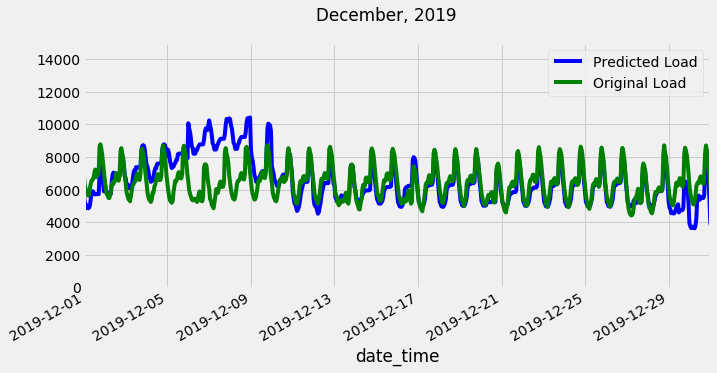

In [48]:
month_wise_plot(df_for_plot, lower_limit='2019-12-01', upper_limit='2019-12-31', Month_name='December')

In [49]:
#df_for_plot=df_for_plot.drop(['date','hour','month','year','dayofmonth'],axis=1)


In [50]:
#df_for_plot.to_csv(r'C:\Users\shumo\Dropbox\Anaconda_directory\Load forecasting\Original_vs_predicted.csv', index = True)

# Load forecasting of 2020

In [51]:
time = pd.date_range(start='2020-01-01 01:00:00', end='2021-01-01', freq='1H')

In [52]:
time.shape

(8784,)

In [53]:
data = np.random.randint(1, high=100, size=len(time))

In [54]:
df_new = pd.DataFrame({'date_time': time, 'loads': data})
df_new = df_new.set_index('date_time')

In [55]:
X_new = create_features(df_new)

In [56]:
X_new.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date_time,,,,,,,,
2020-01-01 01:00:00,1,2,1,1,2020,1,1,1
2020-01-01 02:00:00,2,2,1,1,2020,1,1,1
2020-01-01 03:00:00,3,2,1,1,2020,1,1,1
2020-01-01 04:00:00,4,2,1,1,2020,1,1,1
2020-01-01 05:00:00,5,2,1,1,2020,1,1,1


In [57]:
df_new['MW_Prediction'] = reg.predict(X_new)

In [58]:
df_new.head()

,loads,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction
date_time,,,,,,,,,,,
2020-01-01 01:00:00,37,2020-01-01 01:00:00,1,2,1,1,2020,1,1,1,5314.390625
2020-01-01 02:00:00,12,2020-01-01 02:00:00,2,2,1,1,2020,1,1,1,5042.840820
2020-01-01 03:00:00,55,2020-01-01 03:00:00,3,2,1,1,2020,1,1,1,4879.201660
2020-01-01 04:00:00,87,2020-01-01 04:00:00,4,2,1,1,2020,1,1,1,4754.636719
2020-01-01 05:00:00,17,2020-01-01 05:00:00,5,2,1,1,2020,1,1,1,4639.765137


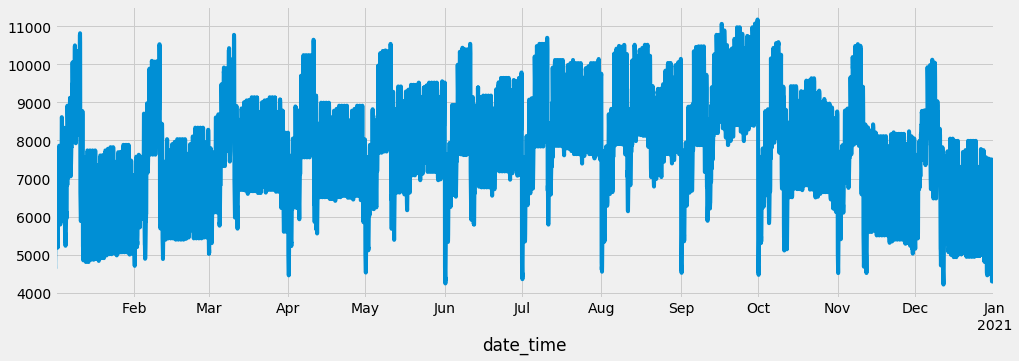

In [59]:
_ = df_new['MW_Prediction'].plot(figsize=(15, 5))

In [60]:
#df_new.shape

## Predict hourwise load

In [61]:
df_new['MW_Prediction']['2020-01-01 01:00:00']

5314.3906

In [62]:
df_2020=df_new['MW_Prediction']

In [63]:
df_2020.shape

(8784,)

In [64]:
df_2020.to_csv(r'C:\Users\Md Samsul Alam\Dropbox\Anaconda_directory\Load forecasting\2020_forecast.csv',index=True)